In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import betainc
import astropy.units as u
import fiasco



In [13]:
k_B = 1.380649e-16 * u.erg / u.K
r_e = 2.81794092e-13 * u.cm
alpha = 0.0072973525693
q_e = 4.80320425e-10 * u.cm**(3/2) * u.g**(1/2) / u.s
pi = np.pi
chi = 13.59844e-3 * u.keV
AU = 1.495978707e13 * u.cm
c = 2.99792458e10 * u.cm / u.s
h = 6.62607015e-27 * u.erg * u.s

In [3]:
iron = fiasco.Element('iron', [1e4]*u.K, 
                      abundance_filename='sun_photospheric_2009_asplund')
A_Fe = iron.abundance   # photospheric abundance from Asplund et al 2009


In [4]:
# Non-thermal recombination [1/keV] from a kappa distribution
def calculate_ntr_kappa(T: u.K, kappa):
    n_min = [2.0, 2.0, 2.0, 2.0, 1.0]
    Ze = [21.98, 22.61, 23.2, 23.77, 25.0]
    pn = [5.0/6.0, 1.0, 1.0, 0.5, 0.5]
    coulomb_log = 20.0
    iron = fiasco.Element('iron', T, 
                      abundance_filename='sun_photospheric_2009_asplund')
    energy = np.arange(0,100,0.01) * u.keV
    omega = ((k_B*T) * (kappa - 1.5)).to(u.keV)
    ntr = np.zeros(len(energy)) / u.keV
    const = (16*r_e**2.0 / (3**1.5 * q_e**4.0 *alpha * coulomb_log)).to(u.keV**-2)
    for i in range(len(energy)):
        for j in range(21, 26):
            phi_e = iron[j].ioneq
            for n in np.arange(n_min[j-21], 21, 1.0):
                J_Z = chi * Ze[j-21]**2.0 / n**2.0
                if energy[i] > J_Z:
                    ion = pn[j-21] * phi_e * Ze[j-21]**4.0 * A_Fe * chi**2.0
                    x = (energy[i] - J_Z)/(energy[i] - J_Z + omega)
                    photons = ((ion * const)  / (energy[i] * n**3.0))
                    ntr[i] += (photons.item()) * (1.0 - betainc(1.5, kappa-0.5, x.value))
    return ntr
                    
# Non-thermal recombination due to a power-law distribution 
#   with cutoff Ec [keV] and index delta
def calculate_ntr_pl(T: u.K, Ec: u.keV, delta):
    n_min = [2.0, 2.0, 2.0, 2.0, 1.0]
    Ze = [21.98, 22.61, 23.2, 23.77, 25.0]
    pn = [5.0/6.0, 1.0, 1.0, 0.5, 0.5]
    coulomb_log = 20.0
    iron = fiasco.Element('iron', T, 
                      abundance_filename='sun_photospheric_2009_asplund')
    energy = np.arange(0,100,0.01) * u.keV
    ntr = np.zeros(len(energy)) / u.keV
    const = (16*r_e**2.0 / (3**1.5 * q_e**4.0 *alpha * coulomb_log)).to(u.keV**-2)
    for i in range(len(energy)):
        for j in range(21, 26):
            phi_e = iron[j].ioneq
            for n in np.arange(n_min[j-21], 21, 1.0):
                J_Z = chi * Ze[j-21]**2.0 / n**2.0
                ion = pn[j-21] * phi_e * Ze[j-21]**4.0 * A_Fe * chi**2.0
                photons = ((ion * const)  / (energy[i] * n**3.0))
                if energy[i] > J_Z + Ec:
                    ntr[i] += (photons.item()) * ((energy[i] - J_Z)/(Ec))**(1.0-delta)
                elif (energy[i] >= J_Z and energy[i] < J_Z + Ec):
                    ntr[i] += (photons.item())
    return ntr

def calculate_ntb_pl(T: u.K, n: u.cm**(-3.0), flux: u.erg/(u.s * u.cm**2.), Ec: u.keV, delta):
    # calculate the two effective Coulomb logarithms:
    avg_energy = Ec * (delta-1.0)/(delta-2.0)
    L1 = 66.0 + 1.5*np.log(avg_energy/u.keV) - 0.5*np.log(n/u.cm**(-3.0))
    L2 = 25.1 + np.log(avg_energy/u.keV)
    area = 1e17*u.cm**2.0
    
    hydrogen = fiasco.Element('hydrogen', T)
    phi_e = hydrogen[1].ioneq
    m_e = 510.99895 * u.keV  # electron mass in keV
    c1 = 16.0*1.4*m_e**2.0*alpha*r_e**2.0/3.0
    c2 = -2.0*pi*alpha
    c3 = (1.0 / (8.0 * pi**2.0 * AU**2.0 * q_e**4.0)).to(1/(u.cm**4.0 * u.keV**2.0))
    
    # Get the points and weights for Gauss-Laguerre quadrature:
    p, w = np.polynomial.laguerre.laggauss(100)
    energy = np.arange(0,100,0.01) * u.keV
    ntb = np.zeros(len(energy)) / (u.cm**2.0 * u.s * u.keV)
    cross_section = np.zeros(len(p)) * (u.cm**2.0 / u.keV)
    
    for i in range(len(energy)):
        if energy[i] == 0.0:
            ntb[i] = 0.0
            continue
        if energy[i] < Ec:
            x = p*u.keV + Ec
        else:
            x = p*u.keV + energy[i]
       
        cross_section = (c1 / (energy[i] * x * (x+2.0*m_e))) * (
            np.log((1.0 + np.sqrt(((x - energy[i])*(x-energy[i]+2.0*m_e))/(x*(x+2.0*m_e))))
                /(1.0-np.sqrt(((x-energy[i])*(x-energy[i]+2.0*m_e))/(x*(x+2.0*m_e)))))
            * np.sqrt(x*(x+2.0*m_e))*(x-energy[i]+m_e) 
            /(np.sqrt((x-energy[i])*(x-energy[i]+2.0*m_e)) *(x+m_e)) 
            * (1.0-np.exp(c2*(x+m_e)/np.sqrt(x*(x+2*m_e)))) 
            / (1.0-np.exp(c2*(x-energy[i]+m_e)/np.sqrt((x-energy[i])*(x-energy[i]+2.0*m_e)))))
        
        integral = np.sum( w * x**(2.0-delta) * np.exp(p) * cross_section)*u.keV

        ntb[i] = ((c3*(delta-2.0)*integral*area*flux.to(u.keV/(u.s*u.cm**2.0)) ) 
                / ((delta-1.0) * Ec**(2.0-delta) * (phi_e*L1 + (1.0-phi_e)*L2)))
    return ntb

def calculate_ntb_kappa(T: u.K, kappa):

    L1 = 20.0
    
    hydrogen = fiasco.Element('hydrogen', T)
    phi_e = hydrogen[1].ioneq
    m_e = 510.99895 * u.keV  # electron mass in keV
    c1 = 16.0*1.4*m_e**2.0*alpha*r_e**2.0/3.0
    c2 = -2.0*pi*alpha
    c3 = (1.0 / (8.0 * pi**2.0 * AU**2.0 * q_e**4.0)).to(1/(u.cm**4.0 * u.keV**2.0))
    omega = ((k_B*T) * (kappa - 1.5)).to(u.keV)

    # Get the points and weights for Gauss-Laguerre quadrature:
    p, w = np.polynomial.laguerre.laggauss(100)
    energy = np.arange(0,100,0.01) * u.keV
    ntb = np.zeros(len(energy)) / (u.keV * u.cm**2.0)
    cross_section = np.zeros(len(p)) * (u.cm**2.0 / u.keV)
    
    for i in range(len(energy)):
        if energy[i] == 0.0:
            ntb[i] = 0.0
            continue
        
        x = p*u.keV + energy[i]
       
        cross_section = (c1 / (energy[i] * x * (x+2.0*m_e))) * (
            np.log((1.0 + np.sqrt(((x - energy[i])*(x-energy[i]+2.0*m_e))/(x*(x+2.0*m_e))))
                /(1.0-np.sqrt(((x-energy[i])*(x-energy[i]+2.0*m_e))/(x*(x+2.0*m_e)))))
            * np.sqrt(x*(x+2.0*m_e))*(x-energy[i]+m_e) 
            /(np.sqrt((x-energy[i])*(x-energy[i]+2.0*m_e)) *(x+m_e)) 
            * (1.0-np.exp(c2*(x+m_e)/np.sqrt(x*(x+2*m_e)))) 
            / (1.0-np.exp(c2*(x-energy[i]+m_e)/np.sqrt((x-energy[i])*(x-energy[i]+2.0*m_e)))))
        
        beta_lim = (x)/(x + omega)
        
        integral = np.sum( w * x * np.exp(p) * cross_section * (1.0 - betainc(1.5, kappa-0.5, beta_lim.value)))*u.keV
        
        ntb[i] = ((c3*integral) / (phi_e*L1))
    return ntb

In [46]:
brems_k2 = calculate_ntb_kappa(1e7*u.K, 2.0)*(1e36/u.s)
const = 1e36/2.812e27 / (u.cm**2 * u.s)
recomb_k2 = calculate_ntr_kappa(1e7*u.K, 2.0)*const
brems_k5 = calculate_ntb_kappa(1e7*u.K, 5.0)*(1e36/u.s)
recomb_k5 = calculate_ntr_kappa(1e7*u.K, 5.0)*const
brems_k10 = calculate_ntb_kappa(1e7*u.K, 10.0)*(1e36/u.s)
recomb_k10 = calculate_ntr_kappa(1e7*u.K, 10.0)*const
brems_k20 = calculate_ntb_kappa(1e7*u.K, 20.0)*(1e36/u.s)
recomb_k20 = calculate_ntr_kappa(1e7*u.K, 20.0)*const

energy = np.arange(0,100,0.01) * u.keV


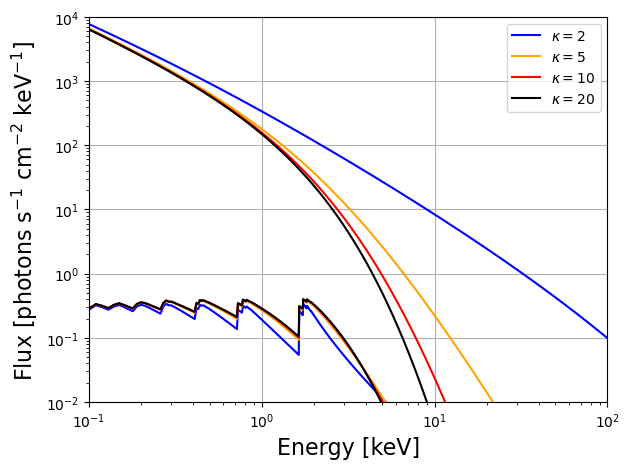

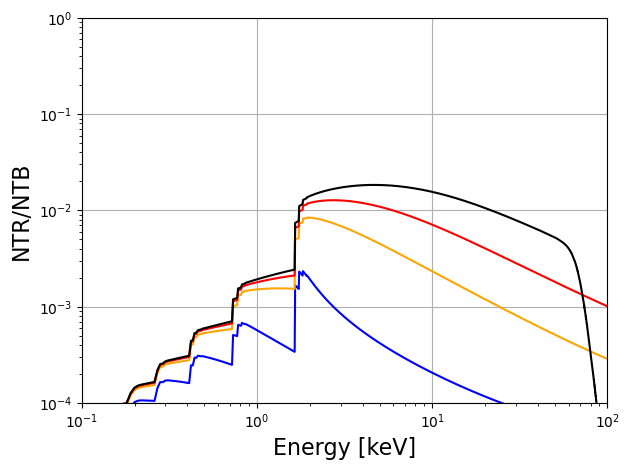

In [48]:
plt.plot(energy,brems_k2, color='blue', label='$\kappa = 2$')
plt.plot(energy,brems_k5, color='orange', label='$\kappa = 5$')
plt.plot(energy,brems_k10, color='red', label='$\kappa = 10$')
plt.plot(energy,brems_k20, color='black', label='$\kappa = 20$')

plt.plot(energy,recomb_k2, color='blue')
plt.plot(energy,recomb_k5, color='orange')
plt.plot(energy,recomb_k10, color='red')
plt.plot(energy,recomb_k20, color='black')

plt.xlabel('Energy [keV]',fontsize=16)
plt.ylabel('Flux [photons s$^{-1}$ cm$^{-2}$ keV$^{-1}$]',fontsize=16)
plt.grid('-')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-1,1e2)
plt.ylim(1e-2,1e4)
plt.tight_layout()
plt.show()

plt.plot(energy,(recomb_k2)/brems_k2, color='blue')
plt.plot(energy,(recomb_k5)/brems_k5, color='orange')
plt.plot(energy,(recomb_k10)/brems_k10, color='red')
plt.plot(energy,(recomb_k20)/brems_k20, color='black')

plt.xlabel('Energy [keV]',fontsize=16)
plt.ylabel('NTR/NTB',fontsize=16)
plt.grid('-')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-1,1e2)
plt.ylim(1e-4,1e0)
plt.tight_layout()
plt.show()



In [5]:
const = 1e36/2.812e27 / (u.cm**2 * u.s)
brems_ec10 = calculate_ntb_pl(2e7*u.K, 1e10*u.cm**(-3.0), 1e11*u.erg/(u.s*u.cm**2.0), 3*u.keV, 7.0)
recomb_ec10 = calculate_ntr_pl(2e7 * u.K, 3*u.keV, 7.0)
energy = np.arange(0,100,0.01) * u.keV



/Users/jreep/anaconda3/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


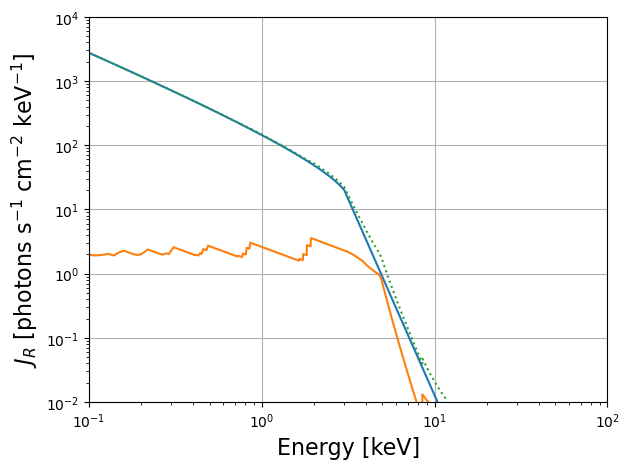

/Users/jreep/anaconda3/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


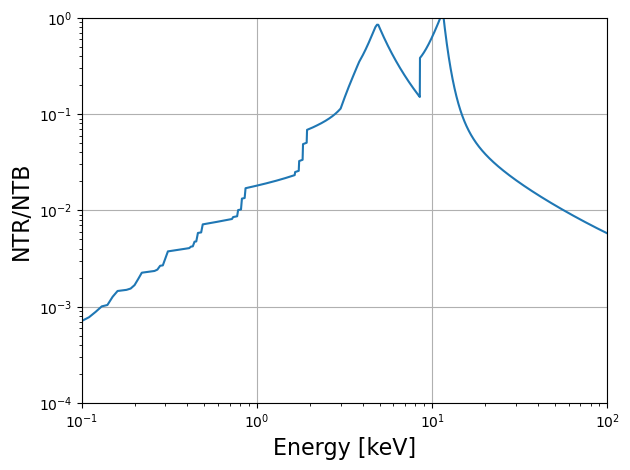

In [6]:
plt.plot(energy,brems_ec10)
plt.plot(energy,recomb_ec10*const)
plt.plot(energy,recomb_ec10*const+brems_ec10,linestyle=':')

plt.xlabel('Energy [keV]',fontsize=16)
plt.ylabel('$J_{R}$ [photons s$^{-1}$ cm$^{-2}$ keV$^{-1}$]',fontsize=16)
plt.grid('-')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-1,1e2)
plt.ylim(1e-2,1e4)
plt.tight_layout()
plt.show()


plt.plot(energy,(recomb_ec10*const)/brems_ec10)
plt.xlabel('Energy [keV]',fontsize=16)
plt.ylabel('NTR/NTB',fontsize=16)
plt.grid('-')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-1,1e2)
plt.ylim(1e-4,1e0)
plt.tight_layout()
plt.show()



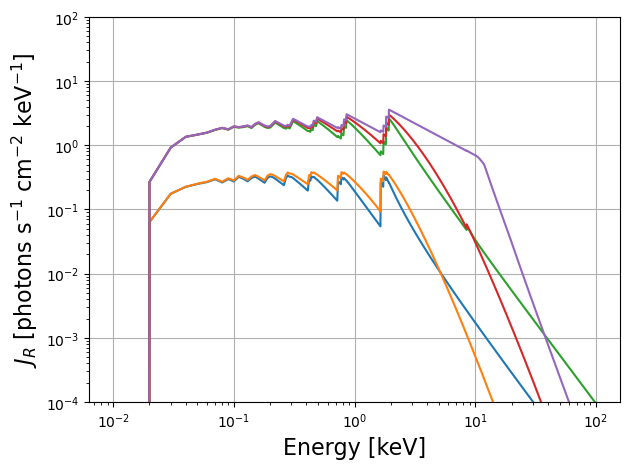

In [99]:
recomb_k2t10 = calculate_ntr_kappa(1e7 * u.K, 2.0)
recomb_k5t10 = calculate_ntr_kappa(1e7 * u.K, 5.0)
recomb_k2t20 = calculate_ntr_kappa(2e7 * u.K, 2.0)
recomb_k5t20 = calculate_ntr_kappa(2e7 * u.K, 5.0)
recomb_ec10 = calculate_ntr_pl(2e7 * u.K, 10 * u.keV, 5.0)


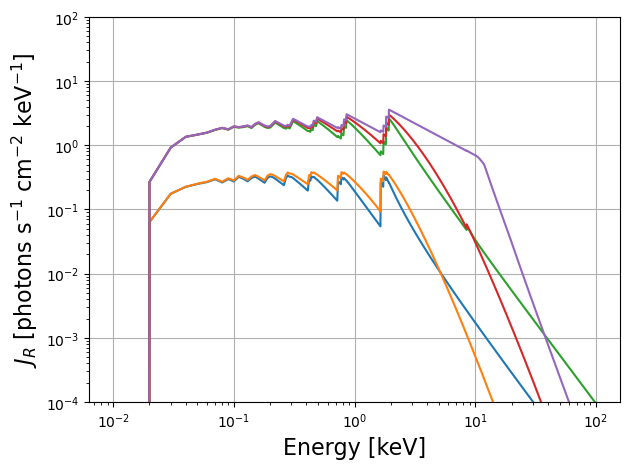

In [100]:
const = 1e36/2.812e27

plt.plot(energy, recomb_k2t10 * const)
plt.plot(energy, recomb_k5t10 * const)
plt.plot(energy, recomb_k2t20 * const)
plt.plot(energy, recomb_k5t20 * const)
plt.plot(energy, recomb_ec10 * const)

plt.xlabel('Energy [keV]',fontsize=16)
plt.ylabel('$J_{R}$ [photons s$^{-1}$ cm$^{-2}$ keV$^{-1}$]',fontsize=16)
plt.grid('-')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1,5)
plt.ylim(1e-4,1e2)
plt.tight_layout()
plt.show()



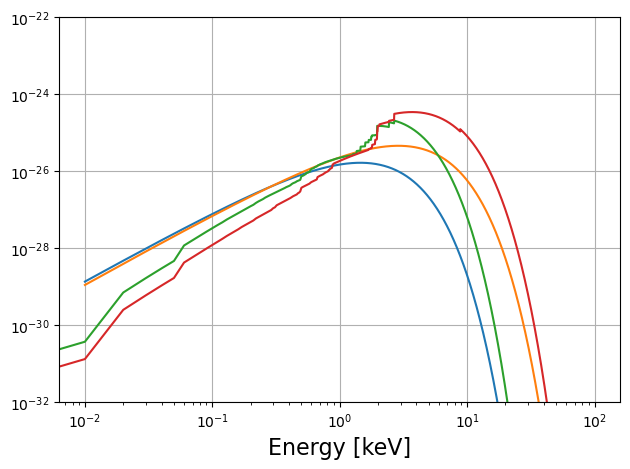

In [57]:
hydrogen = fiasco.Element('H', [1e7,2e7]*u.K)
iron = fiasco.Element('Fe', [1e7,2e7]*u.K)
helium = fiasco.Element('He', [1e7,2e7]*u.K)
silicon = fiasco.Element('Si', [1e7,2e7]*u.K)
magnesium = fiasco.Element('Mg', [1e7,2e7]*u.K)

ions = fiasco.IonCollection(hydrogen, helium,magnesium,silicon, iron)
energy = np.arange(0,100,0.01) * u.keV
wavelength = ((h*c)/energy).to(u.angstrom)
ff = ions.free_free(wavelength)
fb = ions.free_bound(wavelength)

plt.plot(energy, ff[0,:])
plt.plot(energy, ff[1,:])
plt.plot(energy, fb[0,:])
plt.plot(energy, fb[1,:])

plt.xlabel('Energy [keV]',fontsize=16)
plt.grid('-')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1,10)
plt.ylim(1e-32,1e-22)
plt.tight_layout()
plt.show()

